In [1]:
# !pip install pyngrok
# !pip install hyperopt
# !pip install dotenv
# !pip install tensorflow

In [2]:
# !pip install --ignore-installed --force-reinstall mlflow

In [44]:
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.layers import Dense, LeakyReLU, SimpleRNN, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras import models
from keras import layers
# import tensorflow as tf

from mlflow.models import infer_signature
import mlflow.pyfunc
# from pyngrok import ngrok, conf
import mlflow.tensorflow
import mlflow.sklearn
import subprocess
import getpass
import mlflow

from dotenv import load_dotenv
import requests
import logging
import os

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

## Load Dataset

In [4]:
# load_dotenv('.env')
# TOKEN=os.getenv('TOKEN')

In [5]:
# URL=f"https://api.tiingo.com/tiingo/crypto/prices"

# params = {
#     "tickers":"btcusd",
#     "startDate":"2020-01-01",
#     "token":TOKEN,
#     "resampleFreq":"1day"
# }

# headers = {
#     'Content-Type': 'application/json'
# }

In [6]:
# response = requests.get(URL, headers=headers, params=params)

In [7]:
# df = pd.DataFrame(response.json()[0]['priceData'])

In [8]:
# df.head()

In [9]:
# df.to_csv(f"{params['tickers']}_price.csv",index=False)

In [10]:
df = pd.read_csv('btcusd_price.csv')

In [11]:
df_close = df['close']
print(df_close.head())
print(df_close.tail())

0    7196.776430
1    6963.684559
2    7345.355821
3    7354.871466
4    7358.496281
Name: close, dtype: float64
1906    84062.482458
1907    83846.882838
1908    86097.126701
1909    87518.652713
1910    86531.362713
Name: close, dtype: float64


## Data Visualization

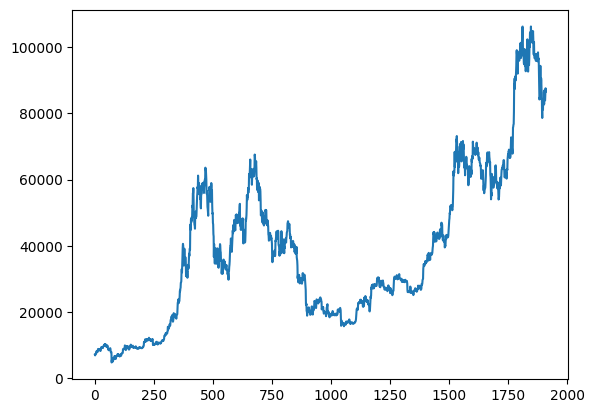

In [12]:
plt.plot(df_close)

## Data Preprocessing

Dataset version:
- v1: MinMax Scaler
- v2: Standard Scaler

- ### MinMax Scaler

In [36]:
min_max_scaler = MinMaxScaler()

In [37]:
df_v1 = min_max_scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [38]:
df_v1

array([[0.02335103],
       [0.02105066],
       [0.02481735],
       ...,
       [0.80201362],
       [0.81604257],
       [0.80629906]])

- ### Standard Scaler

In [39]:
std_scaler = StandardScaler()

In [40]:
df_v2 = std_scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [41]:
df_v2

array([[-1.32743291],
       [-1.33720866],
       [-1.32120157],
       ...,
       [ 1.98160608],
       [ 2.04122413],
       [ 1.99981771]])

- ### Train Test Split

In [19]:
TRAIN_SIZE = int(len(df) * .65) # Train 65% and Test 35%
TEST_SIZE = len(df) - TRAIN_SIZE

In [20]:
def split(df, train_size):
    return df[0:train_size, 0], df[train_size+1:len(df), 0]

In [21]:
train_df_v1, test_df_v1 = split(df_v1, TRAIN_SIZE)
train_df_v2, test_df_v2 = split(df_v2, TRAIN_SIZE)

- ### Converts Time Series Data into pairs of Input (X) and Output (y)

In [22]:
def create_dataset(df, time_step=1):
    '''
    This function used to converts a sequence of time series data into pairs of input (X) and output (y).
    This function creates sliding windows of past observations to predict the next value
    '''
    data_X, data_y = [], []
    for i in range(len(df)-time_step-1):
        temp = df[i:(i+time_step)]
        data_X.append(temp)
        data_y.append(df[i +time_step])
    return np.array(data_X), np.array(data_y)

In [23]:
TIME_STEP = 100

In [24]:
X_train_v1, y_train_v1 = create_dataset(train_df_v1, TIME_STEP)
X_train_v2, y_train_v2 = create_dataset(train_df_v2, TIME_STEP)
X_test_v1, y_test_v1 = create_dataset(test_df_v1, TIME_STEP)
X_test_v2, y_test_v2 = create_dataset(test_df_v2, TIME_STEP)

In [25]:
search_space = {
    "lr": hp.loguniform("lr", -7, -3),  # Learning rate between 1e-7 and 1e-3
    "lstm_units": hp.choice("lstm_units", [32, 50, 64, 128]),  # LSTM units
    "epochs": hp.choice("epochs", [20, 50, 100]),  # Number of epochs
    "batch_size": hp.choice("batch_size", [16, 32, 64, 128]),  # Batch size tuning
    "dataset": hp.choice("dataset", ["v1", "v2"])  # Dataset tuning
}

## Model Building

In [26]:
def train_model(params, epochs):
    if params["dataset"] == "v1":
        X_train, y_train = X_train_v1, y_train_v1
        X_test, y_test = X_test_v1, y_test_v1
    elif params["dataset"] == "v2":
        X_train, y_train = X_train_v2, y_train_v2
        X_test, y_test = X_test_v2, y_test_v2

    model = Sequential()
    model.add(LSTM(params["lstm_units"], return_sequences=True, input_shape=(100, 1)))
    model.add(LSTM(params["lstm_units"], return_sequences=True))
    model.add(LSTM(params["lstm_units"]))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=params["lr"]))

    with mlflow.start_run(nested=True):
        model.fit(X_train, y_train, validation_split=0.2, epochs=params["epochs"], batch_size=params["batch_size"], verbose=0)

        # Evaluate the model
        eval_result = model.evaluate(X_test, y_test, batch_size=params["batch_size"], verbose=0)
        eval_rmse = np.sqrt(eval_result)  # RMSE from MSE loss

        # Log parameters and results
        mlflow.log_params(params)
        mlflow.log_metric("eval_rmse", eval_rmse)

    return {"loss": eval_rmse, "status": STATUS_OK, "model": model, 'dataset': params['dataset']}


In [27]:
def objective(params):
    # MLflow will track the parameters and results for each run
    result = train_model(
        params,
        epochs=3,
    )
    return result

## Model Training

In [28]:
# MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
# subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI])

In [29]:
# print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
# conf.get_default().auth_token = getpass.getpass()
# port=5000
# public_url = ngrok.connect(port).public_url
# print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

In [30]:
# mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [31]:
# mlflow.set_experiment("btc-price-prediction")
# with mlflow.start_run():
#     # Conduct the hyperparameter search using Hyperopt
#     trials=Trials()
#     best=fmin(
#         fn=objective,
#         space=search_space,
#         algo=tpe.suggest,
#         max_evals=4,
#         trials=trials
#     )

#     # Fetch the details of the best run
#     best_run = sorted(trials.results, key=lambda x: x["loss"])[0]
#     best_dataset = best_run['dataset']

#     if best_dataset == "v1":
#         X_sample = X_test_v1[:5]  # Select a small sample for signature
#     else:  # "v2"
#         X_sample = X_test_v2[:5]

#     signature = infer_signature(X_sample, best_run["model"].predict(X_sample))

#     # Log the best parameters, loss, and model
#     mlflow.log_params(best)
#     # mlflow.log_param("dataset", best_run["dataset"])
#     mlflow.log_metric("eval_rmse", best_run["loss"])
#     mlflow.tensorflow.log_model(best_run["model"], "model", signature=signature)

#     # Print out the best parameters and corresponding loss
#     print(f"Best parameters: {best}")
#     print(f"Best eval rmse: {best_run['loss']}")


## Model Inferencing

This is the result of the hyperparameter tuning for Stacked LSTM model in 3 epochs:
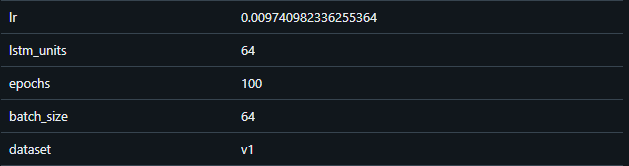
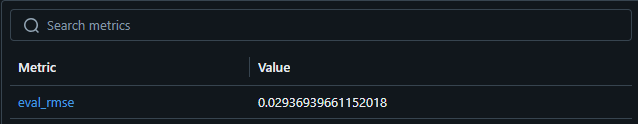

In [33]:
MODEL_URI = 'mlruns/1/d9d4558930dd45afafb0715c53b14e4b/artifacts/model'
model = mlflow.pyfunc.load_model(MODEL_URI)

2025/03/29 14:21:42 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - numpy (current: 2.0.2, required: numpy==2.2.4)
 - tensorflow (current: 2.18.0, required: tensorflow==2.19.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


2025/03/29 14:21:42 WARNING mlflow.pyfunc: The version of Python that the model was saved in, `Python 3.11.11`, differs from the version of Python that is currently running, `Python 3.10.11`, and may be incompatible


In [46]:
train_predict = model.predict(X_train_v1)
test_predict = model.predict(X_test_v1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [47]:
train_predict = min_max_scaler.inverse_transform(train_predict)
test_predict = min_max_scaler.inverse_transform(test_predict)

## Calculating RMSE for both train and test (v1) data

In [48]:
print(f'RMSE for training data (v1): {root_mean_squared_error(train_predict, y_train_v1)}')
print(f'RMSE for testing data (v1): {root_mean_squared_error(test_predict, y_test_v1)}')

RMSE for training data (v1): 34130.69959730697
RMSE for testing data (v1): 65267.23801476573


## Plot the Predicted Train and Test Data

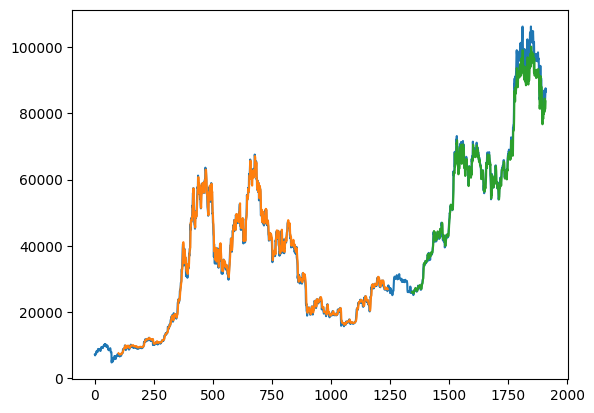

In [53]:
# Plot the predicted value for training data
train_predicted_plot = np.empty_like(df_v1)
train_predicted_plot[:, :] = np.nan
train_predicted_plot[TIME_STEP:len(train_predict)+TIME_STEP, :] = train_predict

# Plot the predicted value for testing data
test_predicted_plot = np.empty_like(df_v1)
test_predicted_plot[:, :] = np.nan
test_predicted_plot[(len(train_predict)+(TIME_STEP*2)+2):(len(df_v1)-1), :] = test_predict

# Plot the actual value
plt.plot(min_max_scaler.inverse_transform(df_v1))
plt.plot(train_predicted_plot)
plt.plot(test_predicted_plot)
plt.show()

## Predict the Price for the next 30 days from the latest date

In [68]:
# We use the test data from index 568 to 668 (to get 100 data from the latest date)
X_input = test_df_v1[568:].reshape(1,-1)

In [69]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [77]:
DAYS_TO_PREDICT = 30 # The number of days to be predicted

lst_output=[]
n_steps=100
i=0
while(i<DAYS_TO_PREDICT):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = X_input.reshape((1, n_steps))
        yhat = model.predict(x_input)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.99975005 0.94067746 0.91337226 0.91728546 0.91188401 0.89090133
 0.88765546 0.92542317 0.93284612 0.89661746 0.88174912 0.89149039
 0.87608948 0.8667451  0.873992   0.88403077 0.90866275 0.9208101
 0.92158717 0.92288225 0.96170475 0.90907789 0.89041225 0.86575721
 0.88694879 0.88564924 0.88502123 0.88516598 0.90506702 0.9442481
 0.93906439 0.97972184 0.98299869 0.95125162 0.96042107 1.
 0.97534784 0.97797357 0.98706796 0.98592597 0.96459953 0.95973548
 0.95202609 0.97618005 0.98599525 0.96300122 0.9454344  0.9161916
 0.95341879 0.91750745 0.90597998 0.90541055 0.9050458  0.90454001
 0.90465291 0.91408125 0.89765302 0.91833967 0.90605774 0.91462006
 0.91549015 0.90105956 0.89776068 0.89616167 0.90612477 0.92290436
 0.90128822 0.90550716 0.90244424 0.85587286 0.82690608 0.78275991
 0.78788517 0.78462017 0.80178634 0.88283433 0.80280655 0.81354478
 0.846611   0.83981017 0.80864751 0.80353927 0.7490747  0.72772157
 0.77071377 0.77802577 0.75251121 0.78128151 0.78494008 0.767

In [78]:
day_new = np.arange(1,101) # Represents the index of the X_input
day_pred = np.arange(101,131) # Represents the index of lst_output

In [80]:
print(len(df_v1))

1911


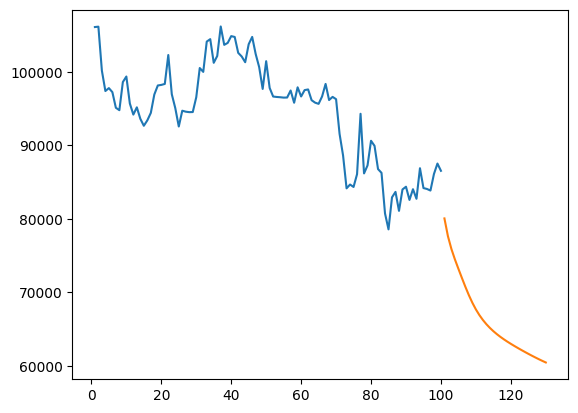

In [81]:
plt.plot(day_new, min_max_scaler.inverse_transform(df_v1[1811:]))
plt.plot(day_pred, min_max_scaler.inverse_transform(lst_output))

In [ ]:
# Combine X_input and lst_output for smoother plotting
combined_df = df_v1.tolist()
combined_df.extend(lst_output)

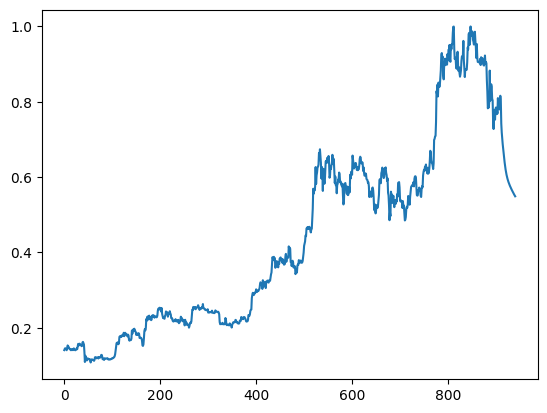

In [83]:
plt.plot(combined_df[1000:])